In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
import pandas as pd
import numpy as np
import gc

# Gradient Boosting
import lightgbm as lgb
import xgboost as xgb

# Scikit-learn
from sklearn.metrics import average_precision_score
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Skopt functions
from skopt import BayesSearchCV
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt.callbacks import DeadlineStopper # Stop the optimization before running out of a fixed budget of time.
from skopt.callbacks import VerboseCallback # Callback to control the verbosity
from skopt.callbacks import DeltaXStopper # Stop the optimization If the last two positions at which the objective has been evaluated are less than delta

# Hyperparameters distributions
from scipy.stats import randint
from scipy.stats import uniform

# Metrics
from sklearn.metrics import average_precision_score, roc_auc_score, mean_absolute_error

import os
import warnings; warnings.filterwarnings("ignore")

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


**Reading the Dataset**

In [4]:
santander_data = pd.read_csv('train.csv')
santander_data_test = pd.read_csv('test.csv')
print('Training df shape',santander_data.shape)
print('Test df shape',santander_data_test.shape)

Training df shape (200000, 202)
Test df shape (200000, 201)


**Let's check the distribution of 'target' value in train dataset**

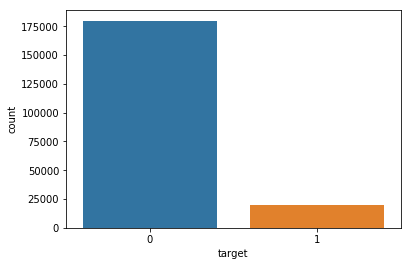

In [5]:
sns.countplot(santander_data['target'])

**Storing the 'target' feature in a separate variable**

In [6]:
label_df = santander_data['target']

**Dropping 'ID_code' and 'target' feature from the Train data and 'ID_code' from the Test data simultaneously**

In [7]:
santander_data.drop(['ID_code','target'], axis=1, inplace=True)

santander_data_test.drop('ID_code', axis=1, inplace=True)
santander_data.head(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


**Checking the Datatypes for all the columns**

In [8]:
santander_data.select_dtypes(exclude=np.number).columns

Index([], dtype='object')

**Storing the train data in 'len_train' variable**

In [9]:
len_train = len(santander_data)
len_train

200000

In [10]:
%%time
santander_data.describe()

CPU times: user 3.33 s, sys: 236 ms, total: 3.56 s
Wall time: 3.69 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [11]:
%%time
santander_data_test.describe()

CPU times: user 3.3 s, sys: 235 ms, total: 3.54 s
Wall time: 3.65 s


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Things we can infer from above: 
1. SD is high for both the Train and Test Dataset.
2. Min, Max , Mean is nearly close to each other for Train and Test set.
3. Mean is largely distributed.

**Merging the Train and Test Dataset**

In [12]:
merged = pd.concat([santander_data, santander_data_test])

**Saving the list of original features in a new list `original_features`**

In [13]:
original_features = merged.columns
merged.shape

(400000, 200)

**Creating new features**

In [14]:
idx = features = merged.columns.values[0:200]
for df in [merged]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [15]:
print("Total number of features: ",merged.shape[1])

Total number of features:  208


In [16]:
train_df = merged.iloc[:len_train]
train_df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,12.7803,-1.0914,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,18.3560,1.9518,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,14.7222,0.3965,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,17.9697,-8.9996,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,17.9974,-8.8104,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [17]:
X_test = merged.iloc[len_train:]
X_test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,15.4722,-8.7197,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,19.1293,-20.9760,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,19.8956,-23.1794,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,13.0168,-4.2108,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,13.9260,-9.1846,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [18]:
train_df = santander_data
X_test = santander_data_test
del santander_data
del santander_data_test
gc.collect()

228

In [32]:
skf_three= StratifiedKFold(n_splits=6, shuffle=True, random_state=2319)

In [33]:
param = {'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1}

In [ ]:
oof_preds = np.zeros(train_df.shape[0])
sub_preds = np.zeros(len(X_test))
feats = [f for f in train_df.columns]
    
for n_fold, (train_idx, valid_idx) in enumerate(skf_three.split(train_df[feats], label_df)):
    trn_data = lgb.Dataset(train_df.iloc[train_idx][feats], label=label_df.iloc[train_idx])
    val_data = lgb.Dataset(train_df.iloc[valid_idx][feats], label=label_df.iloc[valid_idx])
        
    clf = lgb.train(param, trn_data,1000000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 5000)
        

    oof_preds[valid_idx] = clf.predict(train_df.iloc[valid_idx][feats], num_iteration=clf.best_iteration)
    sub_preds += clf.predict(X_test[feats], num_iteration=clf.best_iteration) / 6


print('Full AUC score %.6f' % roc_auc_score(label_df, oof_preds))

pred3=sub_preds

Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.902238	valid_1's auc: 0.87882
[2000]	training's auc: 0.912333	valid_1's auc: 0.886123
[3000]	training's auc: 0.918837	valid_1's auc: 0.890252
[4000]	training's auc: 0.92386	valid_1's auc: 0.892497
[5000]	training's auc: 0.927933	valid_1's auc: 0.893831
[6000]	training's auc: 0.931717	valid_1's auc: 0.894616
[7000]	training's auc: 0.93509	valid_1's auc: 0.895148
[8000]	training's auc: 0.938243	valid_1's auc: 0.895482
[9000]	training's auc: 0.941307	valid_1's auc: 0.895758
[10000]	training's auc: 0.944213	valid_1's auc: 0.895759
[11000]	training's auc: 0.947034	valid_1's auc: 0.895728
[12000]	training's auc: 0.949738	valid_1's auc: 0.895754
[13000]	training's auc: 0.952325	valid_1's auc: 0.895665
[14000]	training's auc: 0.954863	valid_1's auc: 0.895567
Early stopping, best iteration is:
[11252]	training's auc: 0.947735	valid_1's auc: 0.895855
Training until validation scores don't improve for 3500 ro

In [29]:
test_df = pd.read_csv('test.csv')

In [31]:
submission = pd.DataFrame({"ID_code": test_df.ID_code.values})
submission["target"] = pred3
submission.to_csv("submission_900185.csv", index=False)